# Squidpy integration

In this notebook, we will describe some usage principles for using SpatialData with squidpy.

Let's first import some useful libraries and read in a spatialdata dataset.

You might have to install squidpy with `!pip install squidpy`.

In [1]:
from pathlib import Path

import scanpy as sc
import spatialdata as sd
import spatialdata_plot
import squidpy as sq

We chosed a Xenium dataset formatted in the spatialdata format. 
You can download the data from here: [Xenium dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/xenium_rep1_io.zip). Please rename the file to `xenium.zarr` and place it in the same folder as this notebook (or use symlinks to make the data accessible).

In [2]:
sdata = sd.read_zarr("xenium.zarr")
sdata

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object with:
├── Images
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
├── Points
│     └── 'transcripts': DataFrame with shape: (42638083, 8) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (167780, 2) (2D shapes)
│     ├── 'nucleus_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
│     └── 'xenium_landmarks': GeoDataFrame shape: (3, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 167780 × 313
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'

SpatialData has a more complex structure than the spatial anndata format introduced by squidpy. Nevertheless, because it fundamentally uses AnnData as table for annotating regions, 
we can directly use any tool from the scverse ecosystem (squidpy included) to perform downstream analysis.

For example, let's compute a nearest neighbor graph of the spatial coordiantes of the xenium dataset.

In [3]:
sq.gr.spatial_neighbors(sdata.table)

After that, we can cluster the cells based on gene expression profiles and compute clustering.

In [4]:
%%time
sc.pp.pca(sdata.table)
sc.pp.neighbors(sdata.table)
sc.tl.leiden(sdata.table)

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU times: user 1min 40s, sys: 3 s, total: 1min 43s
Wall time: 1min 34s


And run the neighbor enrichment analysis in squidpy.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.11/s]
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


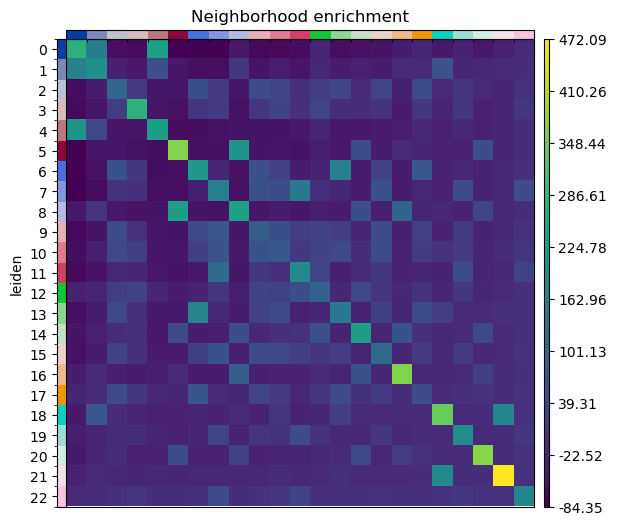

In [5]:
sq.gr.nhood_enrichment(sdata.table, cluster_key="leiden")
sq.pl.nhood_enrichment(sdata.table, cluster_key="leiden", figsize=(5, 5))

We can finally visualize the results in spatial coordinates both with squidpy as well as with the novel plotting function in spatialdata.


/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


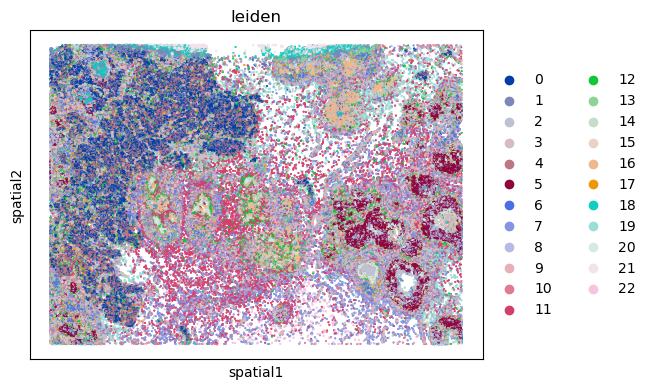

In [6]:
sq.pl.spatial_scatter(sdata.table, shape=None, color="leiden")

INFO     Dropping coordinate system 'aligned' since it doesn't have relevant elements.                             
WARNING  Color key 'leiden' for element 'cell_boundaries' not been found, using default colors.                    


IndexError: index 167780 is out of bounds for axis 0 with size 167780

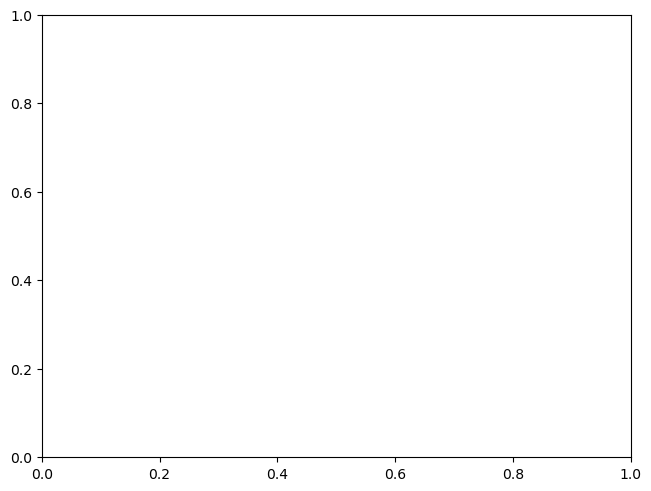

In [7]:
sdata.pl.render_shapes(element="cell_circles", color="leiden").pl.show()